<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [5]:

data = pd.read_csv('Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [6]:
#проверим данные на дубликаты
data.duplicated().sum()

0

In [7]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Дубликатов нет, но в  данных присутствуют пропуски по признаку "Tenure". Так как их менее 10%, удалим такие строки из данных

In [8]:
data=data[data['Tenure']>=0]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        9091 non-null   int64  
 1   CustomerId       9091 non-null   int64  
 2   Surname          9091 non-null   object 
 3   CreditScore      9091 non-null   int64  
 4   Geography        9091 non-null   object 
 5   Gender           9091 non-null   object 
 6   Age              9091 non-null   int64  
 7   Tenure           9091 non-null   float64
 8   Balance          9091 non-null   float64
 9   NumOfProducts    9091 non-null   int64  
 10  HasCrCard        9091 non-null   int64  
 11  IsActiveMember   9091 non-null   int64  
 12  EstimatedSalary  9091 non-null   float64
 13  Exited           9091 non-null   int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.0+ MB


In [9]:
#Сократим количество признаков
#Во-первых, назначим признак "RowNumber" новым индексом с удалением исходной колонки
data = data.set_index('RowNumber')

In [10]:
#Во-вторых, удалим признаки "Surname" и 'CustomerId', так как от них ничего зависеть не будет,

data=data.drop(['Surname', 'CustomerId'], axis =1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
RowNumber,,,,,,,,,,,
1,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
2,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
3,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
4,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
5,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [11]:
#Проверим корреляцию признаков
data.corr()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
CreditScore,1.000000,-0.004504,-0.000062,0.002804,0.011090,-0.003937,0.030947,0.005182,-0.023950
Age,-0.004504,1.000000,-0.013134,0.031481,-0.031877,-0.014129,0.082269,-0.007037,0.283017
Tenure,-0.000062,-0.013134,1.000000,-0.007911,0.011979,0.027232,-0.032178,0.010520,-0.016761
Balance,0.002804,0.031481,-0.007911,1.000000,-0.301858,-0.019055,-0.003285,0.014351,0.117218
NumOfProducts,0.011090,-0.031877,0.011979,-0.301858,1.000000,0.005805,0.009084,0.013990,-0.050271
HasCrCard,-0.003937,-0.014129,0.027232,-0.019055,0.005805,1.000000,-0.008810,-0.006136,-0.005411
IsActiveMember,0.030947,0.082269,-0.032178,-0.003285,0.009084,-0.008810,1.000000,-0.020049,-0.155062
EstimatedSalary,0.005182,-0.007037,0.010520,0.014351,0.013990,-0.006136,-0.020049,1.000000,0.016029
Exited,-0.023950,0.283017,-0.016761,0.117218,-0.050271,-0.005411,-0.155062,0.016029,1.000000


Значимой корреляции между признаками не обнаружено.
Разобьем данные на обучающую, валидационную и тестовую выборки

In [12]:
#Разобьем данные на обучающую, валидационную и тестовую выборки

features = data.drop(['Exited'], axis=1)
target = data['Exited']

print('Количество строк в data', data.shape[0])
print('Количество строк в features', features.shape[0])
print('Количество строк в target', target.shape[0])

features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size = 0.4, random_state = 12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, test_size=0.5, random_state = 12345)

print('Количество строк в обучающей выборке (признаки, значение)', features_train.shape[0], target_train.shape[0])
print('Количество строк в валидационной выборке (признаки, значение)', features_valid.shape[0], target_valid.shape[0])
print('Количество строк в тестовой выборке (признаки, значение)', features_test.shape[0], target_test.shape[0])

Количество строк в data 9091
Количество строк в features 9091
Количество строк в target 9091
Количество строк в обучающей выборке (признаки, значение) 5454 5454
Количество строк в валидационной выборке (признаки, значение) 1818 1818
Количество строк в тестовой выборке (признаки, значение) 1819 1819


В данных осталось 2 категориальных признака: "Geography" и "Gender" - преобразуем их в численные.

В качестве метода преобразования категориальных признаков в численные применим ohe - кодирование

In [13]:
features_train = pd.get_dummies(features_train, drop_first=True)
features_valid = pd.get_dummies(features_valid, drop_first=True)
features_test = pd.get_dummies(features_test, drop_first=True)

features_train.head()


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
9345,727,28,2.0,110997.76,1,1,0,101433.76,0,0,0
3797,537,26,7.0,106397.75,1,0,0,103563.23,0,0,1
7463,610,40,9.0,0.00,1,1,1,149602.54,0,0,1
1509,576,36,6.0,0.00,2,1,1,48314.00,0,0,1
4479,549,31,4.0,0.00,2,0,1,25684.85,0,0,1


Выполним масштабирование численных признаков, чтобы их веса были одинаковыми

In [14]:
scaller = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']
scaller.fit(features_train[numeric])
features_train[numeric] = scaller.transform(features_train[numeric])
features_valid[numeric] = scaller.transform(features_valid[numeric])
features_test[numeric] = scaller.transform(features_test[numeric])
features_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
RowNumber,,,,,,,,,,,
5171,1.707279,-0.756975,-0.336987,-1.237830,2,1,1,0.718362,0,0,0
4181,-0.429826,-0.286389,1.730036,0.485538,2,0,0,1.687305,1,0,1
7350,-0.171721,0.278313,0.352020,-0.269213,2,0,1,0.824128,1,0,1
7470,0.385784,-0.380507,1.041028,0.464813,1,1,0,-1.118018,0,0,0
3468,-1.142194,0.278313,-1.370498,0.353837,2,0,1,-0.107642,1,0,0


Данные готовы к работе

## Исследование задачи

Исследуем баланс классов

In [15]:
#Дисбаланс классов в полном наборе данных
data[data['Exited']==1]['Exited'].count() / data[data['Exited']== 0]['Exited'].count()

0.2561835014508774

In [16]:
#Дисбаланс классов в обучающей выборке
target_train[target_train == 1].count() / target_train[target_train == 0].count()

0.2601663585951941

In [17]:
#Дисбаланс классов в валидационной выборке
target_valid[target_valid == 1].count() / target_valid[target_valid == 0].count()

0.26162387231089523

In [18]:
#Дисбаланс классов в тестовой выборке
target_test[target_test == 1].count() / target_test[target_test == 0].count()

0.2391008174386921

**Исследование моделей**

**Выбор лучшей модели**

Коммит 2: в параметрах моделей изменил глубину ьаксимальную деревьев с 30 до 20

In [19]:
#Создаем функцию, которая по "коду" будет создавать в качестве модели либо решающее дерево, либо лес, 
#либо логистическую регрессию. В качества параметров вводим глубину и кол-во деревьев

def model_type(i, depth=5, state=12345, n_est = 10, weight=None):  
    if i==0:
        model = DecisionTreeClassifier(max_depth = depth, random_state=state, class_weight = weight)
    elif i==1:
        model = RandomForestClassifier(max_depth = depth, random_state=state, n_estimators = n_est, class_weight = weight )
    else:
        model = LogisticRegression(solver='liblinear', random_state=state, class_weight = weight) #, max_iter = dept
    return model

best_model = 0  #Создаем первую пустую модель
best_f1 = 0 #Создаем переменную для хранения лучшего значения f1
auc_roc = 0 #Создаем переменную для хранения  значения roc_auc_score для лучшей по f1 модели

for i in range(0,3):  # Перебираем циклом все 3 модели

    if i == 0 or i == 1: #Если мы работаем с решающим деревом или лесом:
        for depth in range(1, 20):   # Перебираем циклом глубину
            for n in range(1,101,10):    # Перебираем циклом количество деревьев
                test_model = model_type(i, depth, n_est = n*i) # Создаем модель; при этом для "дерева" кол-во деревьев обнулится
                test_model.fit(features_train, target_train)  #Обучаем модель
                predictions_valid = test_model.predict(features_valid)  #Обученная модель предстказывает результат
                

                
#Если результат стал лучше предыдущего лучшего значения, переприсваеваем нашим перменным, отвечающим за 
#хранения лучших данных, и результат и тип модели

                if f1_score(target_valid, predictions_valid) > best_f1:  
                    best_f1 = f1_score(target_valid, predictions_valid)
                    best_model = test_model
                
                    probabilities_valid = test_model.predict_proba(features_valid)
                    probabilities_one_valid = probabilities_valid[:, 1]
                    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                
                
                
                
    else:    #Если мы работаем с логистической регрессией:
        test_model = model_type(i)  # Создаем модель
        test_model.fit(features_train, target_train)  #Обучаем модель
        predictions_valid = test_model.predict(features_valid)  #Обученная модель предсказывает результа
            
        #print(model_type(i, depth), accuracy_score(valid_results,predictions_valid))
        
#Если результат стал лучше предыдущего лучшего значения, переприсваеваем нашим перменным, отвечающим за 
#хранения лучших данных и результат и тип модели   

        if f1_score(target_valid, predictions_valid) > best_f1:
            best_f1 = f1_score(target_valid, predictions_valid)
            best_model = test_model
            
            probabilities_valid = test_model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
            
print('Лучшая модель:', best_model)
print('Лучшее значение f1:', best_f1)
print('Значение roc_auc_score:', auc_roc)


Лучшая модель: RandomForestClassifier(max_depth=17, n_estimators=81, random_state=12345)
Лучшее значение f1: 0.5970149253731343
Значение roc_auc_score: 0.8636225580158193


Коммит 2: Таким образом, получено, что без учета дисбаланса классов наилучшей моделью является RandomForestClassifier с глубиной деревьев 17 и количеством деревьев 81.
Достигаемое этой моделью значение f1-меры составляет 0,6023, что удовлетворяет заданному в ТЗ требованию >= 0,59.
roc_auc - мера, при этом, равна 0,8636, что говорит об адекватности модели.

## Борьба с дисбалансом

Для борьбы с дисбалансом проведем сначала повтор выбора модели, но веса классов сделаем сбалансированными.

In [20]:
best_model = 0  #Обнуляем модель
best_f1 = 0 #Обнуляем переменную для хранения лучшего значения f1
auc_roc = 0 #Обнуляем переменную для хранения  значения roc_auc_score для лучшей по f1 модели

for i in range(0,3):  # Перебираем циклом все 3 модели

    if i == 0 or i == 1: #Если мы работаем с решающим деревом или лесом:
        for depth in range(1, 30):   # Перебираем циклом глубину
            for n in range(1,101,10):    # Перебираем циклом количество деревьев
                # Создаем модель; при этом для "дерева" кол-во деревьев обнулится
                test_model = model_type(i, depth, n_est = n*i, weight = 'balanced') 
                test_model.fit(features_train, target_train)  #Обучаем модель
                predictions_valid = test_model.predict(features_valid)  #Обученная модель предсказывает результат
                

                
#Если результат стал лучше предыдущего лучшего значения, переприсваеваем нашим перменным, отвечающим за 
#хранения лучших данных, и результат и тип модели

                if f1_score(target_valid, predictions_valid) > best_f1:  
                    best_f1 = f1_score(target_valid, predictions_valid)
                    best_model = test_model
                
                    probabilities_valid = test_model.predict_proba(features_valid)
                    probabilities_one_valid = probabilities_valid[:, 1]
                    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                
                
    else:    #Если мы работаем с логистической регрессией:
        test_model = model_type(i, weight='balanced')  # Создаем модель
        test_model.fit(features_train, target_train)  #Обучаем модель
        predictions_valid = test_model.predict(features_valid)  #Обученная модель предсказывает результат
            
        #print(model_type(i, depth), accuracy_score(valid_results,predictions_valid))
        
#Если результат стал лучше предыдущего лучшего значения, переприсваеваем нашим перменным, отвечающим за 
#хранения лучших данных и результат и тип модели   

        if f1_score(target_valid, predictions_valid) > best_f1:
            best_f1 = f1_score(target_valid, predictions_valid)
            best_model = test_model
            
            probabilities_valid = test_model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
            
print('Лучшая модель:', best_model)
print('Лучшее значение f1:', best_f1)
print('Значение roc_auc_score:', auc_roc)


Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=31,
                       random_state=12345)
Лучшее значение f1: 0.6434782608695652
Значение roc_auc_score: 0.8682097055353176


Таким образом, получено, что учет дисбаланса классов позволил выполнить требования ТЗ и достичь значения f1-меры >0.59:
Для модели RandomForestClassifier с глубиной деревьев 9 и количеством деревьев 31 достигнуто значение f1 = 0.6435; 
roc_auc - мера, при этом, также увеличилась и составила 0,8682.

Проведем увеличение обучающей выборки. Так как значений класса 1 примерно в 4 раза меньше, чем класса 0, увеличим количество данных с классом 1.

In [25]:

def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4)

Проведем повторное обучение лучшей модели:

In [27]:
best_model2 = RandomForestClassifier(class_weight='balanced', max_depth=9, n_estimators=31,
                       random_state=12345)
best_model2.fit(features_train_upsampled, target_train_upsampled)  #Обучаем модель на увеличенной обучающей выборке
predictions_valid = best_model2.predict(features_valid)  #Обученная модель предсказывает результат

probabilities_valid = best_model2.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)


print('Значение f1:', f1_score(target_valid, predictions_valid))
print('Значение roc_auc_score:', auc_roc)

Значение f1: 0.6271379703534777
Значение roc_auc_score: 0.8694595743819223


Значение f1-меры уменьшилось! Попробуем заново подобрать наилучшую модель, но уже с использованием увеличенной обучающей выборки:

In [28]:
best_model3 = 0  #Обнуляем модель
best_f1 = 0 #Обнуляем переменную для хранения лучшего значения f1
auc_roc = 0 #Обнуляем переменную для хранения  значения roc_auc_score для лучшей по f1 модели

for i in range(0,3):  # Перебираем циклом все 3 модели

    if i == 0 or i == 1: #Если мы работаем с решающим деревом или лесом:
        for depth in range(1, 30):   # Перебираем циклом глубину
            for n in range(1,101,10):    # Перебираем циклом количество деревьев
                # Создаем модель; при этом для "дерева" кол-во деревьев обнулится
                test_model = model_type(i, depth, n_est = n*i, weight = 'balanced') 
                test_model.fit(features_train_upsampled, target_train_upsampled)  #Обучаем модель
                predictions_valid = test_model.predict(features_valid)  #Обученная модель предстказывает результат
                

                
#Если результат стал лучше предыдущего лучшего значения, переприсваеваем нашим перменным, отвечающим за 
#хранения лучших данных, и результат и тип модели

                if f1_score(target_valid, predictions_valid) > best_f1:  
                    best_f1 = f1_score(target_valid, predictions_valid)
                    best_model3 = test_model
                
                    probabilities_valid = test_model.predict_proba(features_valid)
                    probabilities_one_valid = probabilities_valid[:, 1]
                    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
                
                
    else:    #Если мы работаем с логистической регрессией:
        test_model = model_type(i, weight='balanced')  # Создаем модель
        test_model.fit(features_train_upsampled, target_train_upsampled)  #Обучаем модель
        predictions_valid = test_model.predict(features_valid)  #Обученная модель предстказывает результат
            
        #print(model_type(i, depth), accuracy_score(valid_results,predictions_valid))
        
#Если результат стал лучше предыдущего лучшего значения, переприсваеваем нашим перменным, отвечающим за 
#хранения лучших данных и результат и тип модели   

        if f1_score(target_valid, predictions_valid) > best_f1:
            best_f1 = f1_score(target_valid, predictions_valid)
            best_model3 = test_model
            
            probabilities_valid = test_model.predict_proba(features_valid)
            probabilities_one_valid = probabilities_valid[:, 1]
            auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
            
print('Лучшая модель:', best_model3)
print('Лучшее значение f1:', best_f1)
print('Значение roc_auc_score:', auc_roc)

Лучшая модель: RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=91,
                       random_state=12345)
Лучшее значение f1: 0.6412776412776412
Значение roc_auc_score: 0.8688907828154998


## Тестирование модели

In [29]:
#Проведем тестирование полученной модели, учитывающей вес классов и обученной на исходной выборке без увеличения 
predictions_valid = best_model.predict(features_test)
f1 = f1_score(target_test, predictions_valid)

probabilities_test = best_model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('Полученное значение f1:', f1)
print('Полученное значение roc_auc_score:', auc_roc)

Полученное значение f1: 0.5960264900662252
Полученное значение roc_auc_score: 0.8527407096889387


Требования ТЗ обеспечены

In [30]:
#Проведем тестирование полученной модели, учитывающей вес классов и обученной на увеличенной обучающей выборке
predictions_valid = best_model2.predict(features_test)
f1 = f1_score(target_test, predictions_valid)

probabilities_test = best_model2.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('Полученное значение f1:', f1)
print('Полученное значение roc_auc_score:', auc_roc)

Полученное значение f1: 0.5845410628019323
Полученное значение roc_auc_score: 0.8567405699558289


Требования ТЗ не выполнены! 

In [35]:
#Проведем тестирование заново подобранной модели, учитывающей вес классов и обученной на увеличенной обучающей выборке
predictions_valid = best_model3.predict(features_test)
f1 = f1_score(target_test, predictions_valid)

probabilities_test = best_model3.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
auc_roc = roc_auc_score(target_test, probabilities_one_test)

print('Полученное значение f1:', f1)
print('Полученное значение roc_auc_score:', auc_roc)

Полученное значение f1: 0.6041666666666666
Полученное значение roc_auc_score: 0.8586133817741448


Требования ТЗ обеспечены

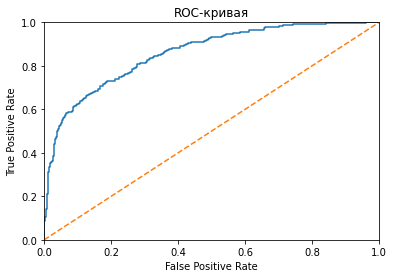

In [33]:
#Построим ROC-кривую лучшей модели:
probabilities_one_test = best_model3.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],  linestyle='--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

**Выводы**

В процесе работы над проектом:
- Проанализированы исходные данные:
    - удалены строки с пропусками;
    - проверена корреляция признаков;
    - удалены неинформативные признаки.
- Выполнена предварительная подготовка данных:
    - данные разбиты на обучающую, валидационную и тестовую выборки;
    - выполнено кодирование категориальных признаков методом OHE;
    - выполнено масштабирование количественных признаков.
- Выполнен анализ дисбаланса классов, показавший существенное различие в количестве классов "0" и "1" (~в 4 раза).
- Выполнен подбор лучшей модели для классификации данных без учета дисбаланса классов.
- Выполнен подбор лучшей модели с учетом дисбаланса классов:
    - Выполнен подбор лучшей модели с учетом дисбаланса классов методом "учета весов";
    - Выполнено увеличение обучающей выборки и расчет метрик на увеличенной выборке для лучшей модели с учетом дисбаланса классов методом "учета весов" модели;
    - Выполнен подбор лучшей модели с учетом дисбаланса классов методом "учета весов" на увеличенной выборке.

В процессе тестирования моделей получено, что наилучший результат, обеспечивающий требования технического задания, дает модель, обученная на увеличенной обучающей выборке с учетом веса классов:

In [36]:
print(best_model3)

RandomForestClassifier(class_weight='balanced', max_depth=11, n_estimators=91,
                       random_state=12345)


Результат метрик указанной модели:

Полученное значение f1: 0.598, что соответствует требованиям ТЗ.

Полученное значение roc_auc_score: 0.8628, что подтверждает адекватность модели.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: задача исследована
    - [x]  Исследован баланс классов
    - [x]  Изучены модели без учёта дисбаланса
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 3: учтён дисбаланс
    - [x]  Применено несколько способов борьбы с дисбалансом
    - [x]  Написаны выводы по результатам исследования
- [x]  Выполнен шаг 4: проведено тестирование
- [x]  Удалось достичь *F1*-меры не менее 0.59
- [x]  Исследована метрика *AUC-ROC*